# Performance metrics in multi-objective optimization
> Implementing and comparing various performance metrics in multi-objective optimization.

- toc: true 
- categories: [multi-objective optimization]
- image: images/hypervolume.png

In multi-objective optimization, the goal is to simultaneously optimize $M$ different and generally conflicting objectives.
Since there is no single solution that is optimal in all objectives, we are instead interested in the Pareto front, composed of the set of points in objective space that are not dominated by any other point ($a$ dominates $b$ if $a$ is equal or better than $b$ in all objectives, and strictly better in at least one objective).
The goal is thus to find a good approximation of the true Pareto front with finite ressources.

To define what a good approximation is, there are three properties that we care for:
1. **Convergence**: The individual points should be optimal, meaning that the distance to the true Pareto front is minimal. 
2. **Spread**: The entire front should be found. The distance between extreme solutions should be maximized.
3. **Distribution**: The Pareto front should be uniformly covered.

In the following we look at different performance metrics for approximate fronts.

## Illustrative example
As example, we consider two objectives to be minimized, where the true Pareto-front forms a quarter-circle of radius $r$ around a center point.
Some of the metrics require a reference front, for which we take the true Pareto-front sampled in 100 equidistant steps.

Now, some optimization algorithms we ran resulted in two approximate fronts $A_1$ and  $A_2$, that we wish to compare. In 2D we can still do this visually and see that set 1 is better in objective 1, whereas set 2 is better in objective 2. The solutions of set 1 are better on average, whereas set 2 has more diverse solutions.

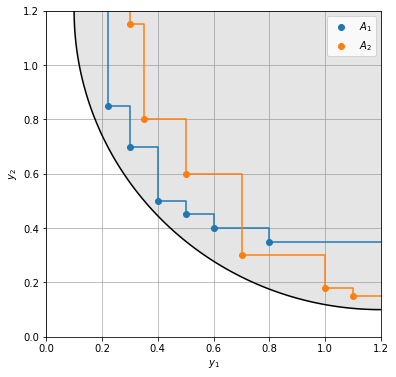

In [1]:
#collapse-hide
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
import pygmo

# two approximate fronts
A1 = np.array([[0.22, 0.85], [0.3, 0.7], [0.4, 0.5], [0.5, 0.45], [0.6, 0.4], [0.8, 0.35]])
A2 = np.array([[0.3, 1.15], [0.35, 0.8], [0.5, 0.6], [0.7, 0.3], [1.0, 0.18], [1.1, 0.15]])

# true Pareto front uniformly sampled by 100 points
φ = np.linspace(0, np.pi / 2, 100)
R = np.array([1.2, 1.2]) - 1.1 * np.array([np.sin(φ), np.cos(φ)]).T

def plot_pareto_front(ax=None): 
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.fill_between(R.T[0], R.T[1], 1.2, color='gray', alpha=0.2)
    ax.plot(*R.T, color='k')
    ax.set(xlim=(0, 1.2), ylim=(0, 1.2), xlabel='$y_1$', ylabel='$y_2$')
    ax.grid()
    ax.set_axisbelow(True)
    return ax

def plot_attainment(A, ax=None):
    """Plot the attainment surface for m=2 objectives"""
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6, 6))
    N, m = A.shape
    assert m == 2, ValueError("A has to be of shape (n, 2)")
    S = np.zeros((N + 2, 2))
    S[1:-1] = A[np.argsort(A[:, 0])]  # sort along x-axis
    S[0] = np.min(A[:, 0]), 1.2
    S[-1]= 1.2, np.min(A[:, 1]) 
    ax.step(*S.T, where='post')

ax = plot_pareto_front()
ax.scatter(*A1.T, label='$A_1$')
plot_attainment(A1, ax=ax)
ax.scatter(*A2.T, label='$A_2$')
plot_attainment(A2, ax=ax)
ax.legend();

## Hypervolume indicator

The hypervolume indicator {% cite Zitzler1999 %} measures the volume in the objective space that is dominated by a set, bounded by a reference point.
Larger values indicate better convergence, spread and distribution.  
The hypervolume is sensitive to the choice of the reference point. For more distant reference points, the difference in dominated hypervolume decreases.
In practice we can take a reference point that is slightly worse than the combination of the worst objective values from the evaluated Pareto front (the nadir).
A more principled choice of the reference point is given in {% cite Ishibuchi2018 %}.  

Choosing (1.2, 1.2) as reference point we get that set 1 covers a significantly larger hypervolume than set 2.

In [2]:
#collapse-hide
ref_point = [1.2, 1.2]
print(f'Set 1: volume={pygmo.hypervolume(A1).compute(ref_point):.3f}')
print(f'Set 2: volume={pygmo.hypervolume(A2).compute(ref_point):.3f}')

Set 1: volume=0.723
Set 2: volume=0.659


The difference in hypervolume between set 1 and 2 shrinks if we choose a more distant reference point.

In [3]:
#collapse-hide
ref_point = [1.5, 1.5]
print(f'Set 1: volume={pygmo.hypervolume(A1).compute(ref_point):.3f}')
print(f'Set 2: volume={pygmo.hypervolume(A2).compute(ref_point):.3f}')

Set 1: volume=1.362
Set 2: volume=1.335


## Exclusive hypervolume contribution

The exclusive hypervolme contribution measures the volume that is exclusively dominated by a given point in a set.  
For the extremal points a reference point is again necessary to define a volume. If the nadir is chosen as reference point, the extremal points have 0 exclusive contribution. For all non-extremal points the contribution is independent of the reference. Here, small values indicate that a point carries little additional information and can be pruned away.

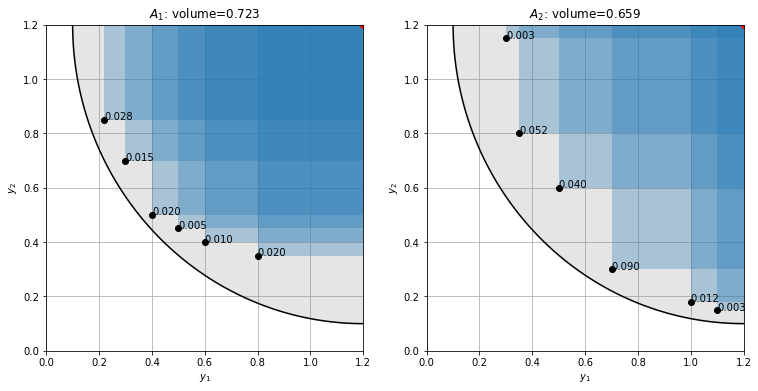

In [4]:
#collapse-hide
def plot_hypervolume(points, ref_point, ax=None):
    contributions = pygmo.hypervolume(points).contributions(ref_point)
    
    if ax is None:
        fig, ax = plt.subplots(1, figsize=(6, 6))
    
    # plot dominated volume for each point
    for p in points:
        w, h = ref_point - p
        ax.add_patch(plt.Rectangle(p, w, h, alpha=0.3))
    
    # annotate each point with its exclusive contribution
    for p, c in zip(points, contributions):
        ax.annotate(f"{c:.3f}", p)
    
    ax.plot(points[:, 0], points[:, 1], 'ko', label='front')
    ax.plot(ref_point[0], ref_point[1], 'ro', label='reference')    

ref_point = [1.2, 1.2]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 6))
plot_pareto_front(ax=ax1)
plot_pareto_front(ax=ax2)
plot_hypervolume(A1, ref_point, ax=ax1)
plot_hypervolume(A2, ref_point, ax=ax2)
ax1.set_title(f'$A_1$: volume={pygmo.hypervolume(A1).compute(ref_point):.3f}')
ax2.set_title(f'$A_2$: volume={pygmo.hypervolume(A2).compute(ref_point):.3f}');

## Crowding distance

The crowding distance {% cite Deb2000 %} calculates for each point in a non-dominated set the average side length of the cuboid formed by the neighboring points. This provides a measure of the local density at each point. Points with small crowding distance can be pruned out without losing too much information. In a uniformly populated front, each point will have a similar crowding distance.  
The crowding distance is thus similar to the exclusive hypervolume contribution, only that here the side length and not the volume is considered.

In [5]:
#collapse-show
def crowding_distance(A):
    N, m = A.shape
    
    # no crowding distance for lesss than 2 points
    if N <= 2:
        return np.full(N, np.inf)
    
    # sort points along each objective
    sort = np.argsort(A, axis=0)
    A = A[sort, np.arange(m)]
    
    # normalize all objectives
    norm = np.max(A, axis=0) - np.min(A, axis=0)
    A = A / norm
    A[:, norm == 0] = 0  # handle min = max

    # distance to previous and to next point along each objective
    d = np.diff(A, axis=0)
    inf = np.full((1, m), np.inf)
    d0 = np.concatenate([inf, d])
    d1 = np.concatenate([d, inf])

    # cuboid side length = sum of distance to previous and next point
    unsort = np.argsort(sort, axis=0)
    cuboid = d0[unsort, np.arange(m)] + d1[unsort, np.arange(m)]
    return np.mean(cuboid, axis=1)

Calculating the crowding distances in our example, we can quantify our observation that the points are more evenly distributed in set 2. In set 1 there is a point with a significantly smaller crowding distance we could prune away.

One might wonder why both sets have similar crowding distance values even though the cuboids (i.e. distances to neighboring points) are larger in set 2. This is because the sides of the cuboids are normalized to the objective value range in the approximate front and set 2 has a larger spread.

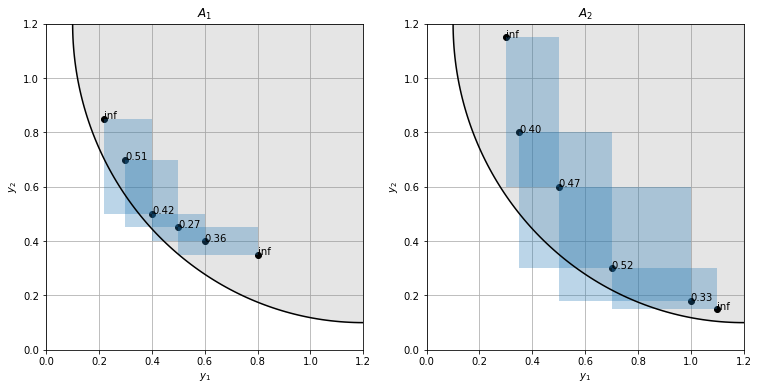

In [6]:
#collapse-hide
def plot_crowding(A, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize(6, 6))
    N, m = A.shape
    for i in range(1, N - 1):
        a0 = A[i - 1]
        a1 = A[i + 1]
        ax.add_patch(plt.Rectangle(a0, *(a1 - a0), alpha=0.3, linewidth=2))
    ax.scatter(*A.T, color='k')
    for a, d in zip(A, crowding_distance(A)):
        ax.annotate(f"{d:.2f}", a)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 6))
for ax, A in zip((ax1, ax2), (A1, A2)):
    plot_pareto_front(ax=ax)
    plot_crowding(A, ax=ax)
ax1.set_title(f'$A_1$')
ax2.set_title(f'$A_2$');

## Epsilon-indicator

An objective vector $a$ is said to $\epsilon$-dominate $b$ if $a_i < \epsilon \cdot b_i ~ \forall i=1 \ldots m$ where $\epsilon < 1$ is a scalar.  
The binary $\epsilon$-indicator $I_\epsilon(A, B)$ is defined as the smallest $\epsilon$ value for which any vector in $B$ is $\epsilon$-dominated by a vector in $A$ {% cite Zitzler2003 %}.
\begin{align}
I_\epsilon(A, B) = \max_\limits{b \in B} \min_\limits{a \in A} \max_\limits{1 \leq i \leq m} \frac{a_i}{b_i}
\end{align}
The unary $\epsilon$-indicator is defined as $I_{\epsilon 1}(A) = I_\epsilon(A, R)$ where $R$ is the reference front (Pareto-front or a good approximation to it).

If we use the additive $\epsilon$-dominance ($a_i < b_i + \epsilon ~ \forall i = 1 \ldots m$) instead, we get the additive $\epsilon$-indicator. 
\begin{align}
I_{\epsilon+}(A, B) = \max_\limits{b \in B} \min_\limits{a \in A} \max_\limits{1 \leq i \leq m} (a_i - b_i)
\end{align}

In [7]:
#collapse-show
def epsilon_indicator(A, B, additive=False):
    if additive:
        r = A[:, np.newaxis, :] - B[np.newaxis, :, :]
    else:  # multiplicative
        r = A[:, np.newaxis, :] / B[np.newaxis, :, :]
    return r.max(axis=2).min(axis=0).max()

For the multiplicative $\epsilon$-indicator we get

In [8]:
#collapse-hide
print(f'Set 1: I_ε1={epsilon_indicator(A1, R):.3f}')
print(f'Set 2: I_ε1={epsilon_indicator(A2, R):.3f}')

Set 1: I_ε1=3.500
Set 2: I_ε1=3.000


For the additive $\epsilon$-indicator we get

In [9]:
#collapse-hide
print(f'Set 1: I_ε1={epsilon_indicator(A1, R, True):.3f}')
print(f'Set 2: I_ε1={epsilon_indicator(A2, R, True):.3f}')

Set 1: I_ε1=0.250
Set 2: I_ε1=0.220


## Generational distance

The generational distance (GD) {% cite Veldhuizen2000 %} is defined as the average distance of points in the approximate front $A$ to a reference front $R$, which is either the actual Pareto front or a very good approximation to it.

\begin{align}
\mathrm{GD}(A, R) = \frac{1}{N_A} \left(\sum\limits_{a \in A} d(a, R)^p \right)^{1/p}
\end{align}
where $d(a, R)$ is the euclidean distance of $a$ to the reference front.
With the default choice of $p=1$, GD is simply the average distance.  

GD is a measure of the convergence.

In [10]:
#collapse-show
def distance(A, B):
    """Calculate for each point in A the distance to B"""
    d = A[:, np.newaxis] - B[np.newaxis]  # shape (len(A), len(B), m)
    return np.linalg.norm(d, axis=2).min(axis=1)

def generational_distance(A, R, p=1):
    return np.linalg.norm(distance(A, R), p) / len(A)

In the example, set 1 achieves a better GD-value as its points are closer to the Pareto front (better convergence).

In [11]:
#collapse-hide
print(f'GD(A,R1) = {generational_distance(A1, R):.3f}')
print(f'GD(A,R2) = {generational_distance(A2, R):.3f}')

GD(A,R1) = 0.084
GD(A,R2) = 0.119


## Inverted generational distance

The inverted generationl distance (IGD) {% cite Coello2004 %} simply reverses the role of approximate front and reference front, i.e. $\mathrm{IGD}(A, R) = \mathrm{GD}(R, A)$. Thus it calculates the average distance between each point in the reference front $R$ to the closest point in the approximated front $A$.

IGD simultaneously measures convergence, spread and distribution.  
In the example, set 2 achieves a better IGD-value due to its better spread and distribution.

In [12]:
#collapse-hide
print(f'IGD(A1,R) = {generational_distance(R, A1):.3f}')
print(f'IGD(A2,R) = {generational_distance(R, A2):.3f}')

IGD(A1,R) = 0.174
IGD(A2,R) = 0.157


## Modified (inverted) generational distance

The GD / IGD metrics cannot differentiate the quality of points in the approximate front when they are non-dominated by the reference front.
To fix this, a modified distance measure can be used {% cite Ishibuchi2015 %}
\begin{align}
d^+(a, R) = \min_{r \in R} \sqrt{ \sum_{i=1}^m \max(a_i - r_i, 0)^2 }
\end{align}
i.e. setting negative components of the difference $a - r$ to zero before calculating the euclidean distance.  
With this modification we get the modified generational distance GD$^+$ and the modified inverted generational distance IGD$^+$.

In [13]:
#collapse-show
def modified_distance(A, B):
    """Calculate for each point in A the modified distance to B"""
    d = (A[:, np.newaxis] - B[np.newaxis]).clip(0, None)
    return np.linalg.norm(d, axis=2).min(axis=1)

def modified_generational_distance(A, R, p=1):
    return np.linalg.norm(modified_distance(A, R), p) / len(A)

In our example the approximate fronts are dominated by the reference front, so the GD / GD$^+$ and IGD / IGD$^+$ are the same.
To see the effect we add the infeasible point (0.3, 0.3) to the approximate front.

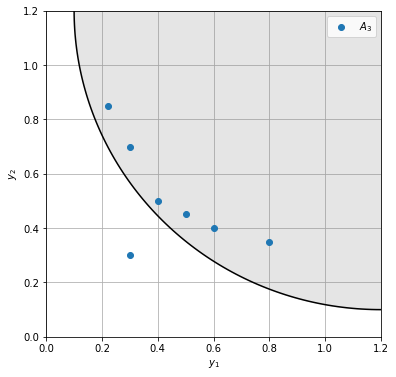

In [14]:
#collapse-hide
A3 = np.r_[A1, [[0.3, 0.3]]]
ax = plot_pareto_front()
ax.scatter(*A3.T, label='$A_3$')
ax.legend();

Although the approximate front is better with this point than without, the GD increases (IGD stays the same since for each point in $R$ there is a closer point than the newly added one). In contrast the modified versions correctly indicate an improvement. 

In [15]:
#collapse-hide
print(f'GD(A1,R) = {generational_distance(A1, R):.3f}')
print(f'GD(A3,R) = {generational_distance(A3, R):.3f}')
print(f'GD+(A3,R) = {modified_generational_distance(A3, R):.3f}')

GD(A1,R) = 0.084
GD(A3,R) = 0.097
GD+(A3,R) = 0.072


In [16]:
#collapse-hide
print(f'IGD(A1,R) = {generational_distance(R, A1):.3f}')
print(f'IGD(A3,R) = {generational_distance(R, A3):.3f}')
print(f'IGD+(A3,R) = {modified_generational_distance(R, A3):.3f}')

IGD(A1,R) = 0.174
IGD(A3,R) = 0.174
IGD+(A3,R) = 0.086


## Attainment surface quantiles

The approximate front is also called attainment surface. For several runs of an multi-optimization algorithm, the *quantiles* of the approximate front can be calculated, indicating the boundaries of the dominated volume that are likely to be attained with some probability.

In 2 and 3 dimensions attainment surfaces can be used for visual inspection. For quantification and higher dimensions they can be used for binary metrics in the form of statistical comparisons.

## References

{% bibliography --cited %}